# Data exploration

This notebook will explore the images we have and extract data from them. The images have 4 channels (DAPI, EdU, and two Alexa's, one being PCNA). The data we extract from the channels are the pixel intensities.

## Importing data

Note: since I'm working from home right now, I'm struggling with my connection to Omero so I'm importing data I saved from earlier. When I'm back in the lab I will change this part to be importing data from Omero with the plate number.

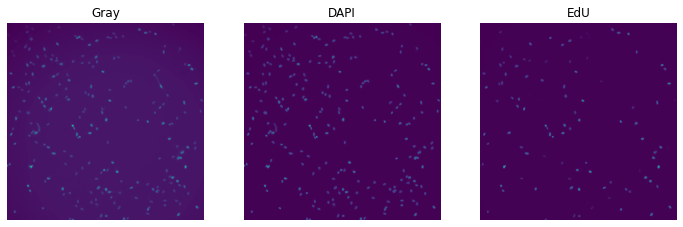

In [6]:
#Here we get the images from a directory in the project and display them

import numpy as np
import matplotlib.pyplot as plt

gray_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/gray_img.npy')
dapi_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/dapi_img.npy')
edu_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/cy5_img.npy')

plt.figure(figsize=(12,12))
plt.subplot(1,3,1);plt.imshow(gray_img);plt.axis('off');plt.title('Gray')
plt.subplot(1,3,2);plt.imshow(dapi_img);plt.axis('off');plt.title('DAPI')
plt.subplot(1,3,3);plt.imshow(edu_img);plt.axis('off');plt.title('EdU');plt.show()

In [15]:
#Make a segmentation prediction, right now with the Gray image as that's all we have, later with the Alexa555 (PCNA) image

from cellpose import models
model_dir = "/Users/rehanzuberi/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model"
model = models.CellposeModel(gpu=True, pretrained_model=model_dir)
test_data = [gray_img]
predicted_test_masks = model.eval(test_data, channels=[0,0], diameter=model.diam_labels.copy())[0]  # generates the predictions # we could use the fact that it has a channel input to have the normal image not separated by channel and just make it do the prediction on there, although we need it to make a prediction on the averaged out gray image so that wouldn't really work
predicted_mask = predicted_test_masks[0]

In [20]:
#Now we get the crops from each channel and store them in a numpy array
from segmentation.seg_functions import count_cells, get_cell_crop_coordinates, get_img_crops

print('Prediction has', count_cells(predicted_mask), 'cells')
crop_coordinates = get_cell_crop_coordinates(predicted_mask)
gray_crops = get_img_crops(gray_img, crop_coordinates)
dapi_crops = get_img_crops(dapi_img, crop_coordinates)
edu_crops = get_img_crops(edu_img, crop_coordinates)

#We could have one numpy array called 'cells' that holds the images and later on the values

Prediction has 146 cells


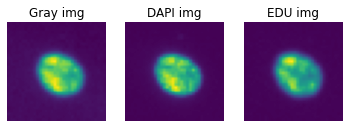

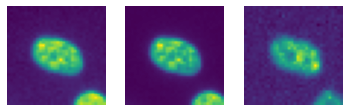

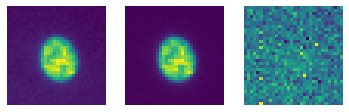

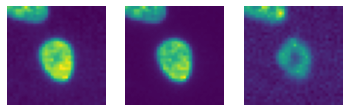

In [25]:
for i in range(4):
    plt.subplot(1,3,1)
    if i == 0: plt.title('Gray img')
    plt.axis('off')
    plt.imshow(gray_crops[i])

    plt.subplot(1,3,2)
    if i == 0: plt.title('DAPI img')
    plt.axis('off')
    plt.imshow(dapi_crops[i])

    plt.subplot(1,3,3)
    if i == 0: plt.title('EDU img')
    plt.imshow(edu_crops[i])
    plt.axis('off')
    plt.show()

In [ ]:
#This is what we used to measure the pixel intentisty values of the cells on different channels
#We would put them into one array
#Now I think I would prefer putting them into each their own numpy array
#This also depends on what Helfrid's normalisation funcitions ofers
dapi_cy5_values = []
for i in range(len(cy5_crops)):
    dapi_avg = np.average(dapi_crops[i])
    cy5_avg = np.average(cy5_crops[i])
    dapi_cy5_values.append(np.array([dapi_avg,cy5_avg]))

dapi_cy5_values = np.array(dapi_cy5_values)

In [ ]:
#Helfrid's normalisation function

def dna_norm(df):
    """
    normalise histogram of DNA label
    :param df: input dataframe
    :return: input dataframe with additional column: "DNA_content"
    """
    y, x, _ = plt.hist(df['integrated_int_DAPI'], bins=250)
    max=x[np.where(y == y.max())]
    df['DNA_content']=df['integrated_int_DAPI']/max[0]
    return df